# Speech spectrogram classification

## Spectrogram 데이터를 이용해 음성을 분류하는 모델을 제작해보자.

## challenge
### Task
* 1초 길이의 오디오 음성데이터를 이용해 단어를 분류하는 것이 목표입니다.
* 주어진 데이터를 이용해 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* This code is borrowed from [Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).
* This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.
* **챌린지에서 사용하는 데이터는 Wave에서 Spectrogram으로 변환된 데이터입니다.**

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import matplotlib.pyplot as plt

import os
from os.path import isdir, join

import random
import copy

tf.__version__

'2.15.0'

### Setting Dataset

* Colab 적용을 위한 변수 지정 및 드라이브 마운트

In [ ]:
use_colab = True
assert use_colab in [True, False]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if use_colab:
    DATASET_PATH = "/content/drive/MyDrive/Datasets"
else:
    DATASET_PATH = "./"

### Dataset Shape
* 불러온 데이터셋의 shape을 확인해보자.

In [5]:
data_wav = np.load(os.path.join(DATASET_PATH, "speech_spec_8000.npy"))
print(data_wav.shape)
# 50620, 130, 126, 1

(50620, 130, 126)


In [6]:
(-1, data_wav.shape[1], data_wav.shape[2], 1)

(-1, 130, 126, 1)

* Spectrogram으로 변환한 데이터를 plot 해본다.

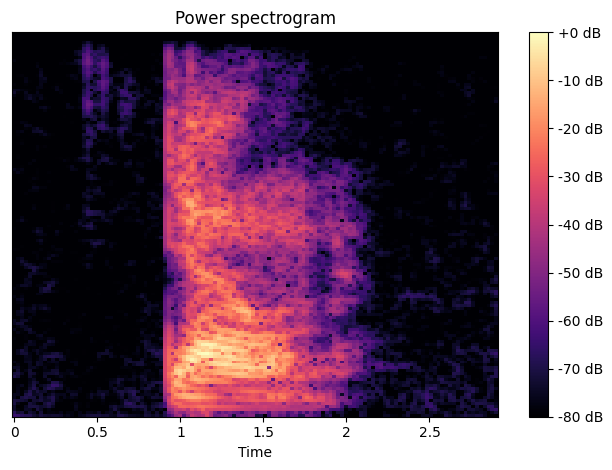

In [7]:
librosa.display.specshow(librosa.amplitude_to_db(data_wav[219], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

* 전체 데이터셋의 wave 데이터를 spectrogram으로 변환한다.

### Target_list 설정
* 데이터셋은 기본적으로 총 12개의 클래스로 나누어져있다.
```
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
```
* 해당 클래스로 나누어진 label을 학습 가능한 형태로 처리 후 데이터셋 제작

In [8]:
data_label = np.load(os.path.join(DATASET_PATH, "speech_label_8000.npy"))
print(data_label.shape)

(50620, 1)


In [10]:
# label 전처리
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
##################################################
##### 주어진 label => idx 형태로 변경해주셔야합니다. #####
##################################################

new_label_value = dict() # 사전에 입력
for i, l in enumerate(target_list):
    new_label_value[l] = i
target_list = new_label_value # 일종의 번역사전을 만들게 됩니다.

In [12]:
target_list

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

### Model dataset setting
* 변환된 데이터를 이용해서 학습에 활용할 데이터셋을 설정한다.
    * data -> data_wav
    * label -> data_label

In [17]:
print("data_wav 길이:", len(data_wav))
print("data_label 길이:", len(data_label))

data_wav 길이: 50620
data_label 길이: 50620


In [19]:
train_wav, test_wav, train_label, test_label = \
train_test_split(data_wav, data_label, test_size=0.1, shuffle=True)

# reshape for conv layers Conv2D -> 차원이 더 늘어납니다. 데이터 shape도 바뀝니다!
train_wav = train_wav.reshape([-1, 130, 126, 1])
test_wav = test_wav.reshape([-1, 130, 126, 1])

print(train_wav.shape)
print(test_wav.shape)
print(train_label.shape)
print(test_label.shape)

del data_wav # 메모리 관리를 위해 변수 삭제
del data_label

(45558, 130, 126, 1)
(5062, 130, 126, 1)
(45558, 1)
(5062, 1)


In [21]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(target_list)))

Train_Wav Demension : (45558, 130, 126, 1)
Train_Label Demension : (45558, 1)
Test_Wav Demension : (5062, 130, 126, 1)
Test_Label Demension : (5062, 1)
Number Of Labels : 12


## Label 데이터 구분화
* label vector화 -> 학습 가능한 형태로 변환 (여기서는 정답 데이터로)

In [25]:
# temp 변수를 이용해서 기존 text 형태인 label을 idx 형태로 변경해준다.
temp = []
for v in train_label:
    temp.append(target_list[v[0]]) # ["down"] => "down"
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(target_list[v[0]])
test_label = np.array(temp)

del temp

In [27]:
train_label[0:10]

array([ 3,  9,  3,  7,  1, 10, 10, 11,  1,  8])

### Hyper-parameters setting
* 학습 전반에서 사용할 batch size, epoch, checkpoint dir을 설정한다.

In [28]:
# the save point
if use_colab:
    checkpoint_dir ='./drive/MyDrive/train_ckpt/spectrogram/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'spectrogram/exp1'

### Dataset 구성
* 전처리가 완료된 데이터들을 이용해서 Train, Test Dataset을 직접 구성해봅시다.
* 학습에 사용할 Loss Function의 설정을 고려해 제작


In [29]:
# mapping 함수를 이용해 데이터셋 아웃풋을 처리
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

# [0, 1, 2]

# 0 => [1, 0, 0]
# 1 => [0, 1, 0]
# 2 => [0, 0, 1]

In [30]:
# 전체 데이터셋 구성
batch_size = 16

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.shuffle(10000).repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size) # 테스트때는 섞을 필요가 없다!
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 130, 126, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 130, 126, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>


In [31]:
for t, l in train_dataset.take(1):
    print(l)

tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(16, 12), dtype=float32)


### Dataset 구성 검증
```
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
```

## Model 구현
* 제시된 모델을 구현해보고, 더 좋은 성능으로 튜닝해보자.

    * inputs = [batch_size, 130, 126, 1]
    * conv1 = [batch_size, 65, 63, 16]
    * conv2 = [batch_size, 33, 32, 32]
    * conv3 = [batch_size, 17, 16, 64]
    * desne = [batch_size, 64]
    * output = [batch_size, 12]






### Model dataset setting
* Conv1D, 2D (파라미터 비슷)
* Conv2D(6,3) -> N=6, 3*3 = 9
* Conv1D(6,9) -> N=6, 9

In [35]:
# Conv Layer (Sequential) Conv2D(6,3) -> N=6, 3*3 = 9

# inputs = [batch_size, 130, 126, 1]
input_tensor = layers.Input(shape=(130, 126, 1))
x = layers.Conv2D(16, 3, padding='same', activation='relu')(input_tensor)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(16, 3, strides=2, padding='same', activation='relu')(x) # strides=2 (1/2)

# conv1 = [batch_size, 65, 63, 16]
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(x) # strides=2 (1/2)

# conv2 = [batch_size, 33, 32, 32]
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x) # strides=2 (1/2)

# conv3 = [batch_size, 17, 16, 64]
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x) # strides=2 (1/2)
x = layers.Dropout(0.3)(x)

# desne = [batch_size, 64]
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# output = [batch_size, 12]
output_tensor = layers.Dense(12)(x)

model = tf.keras.Model(input_tensor, output_tensor)

print(x.shape)

(None, 64)


In [ ]:
# Conv Layer (Sequential) Conv2D(6,3) -> N=6, 3*3 = 9
# Skip Connection 추가

# inputs = [batch_size, 130, 126, 1]
input_tensor = layers.Input(shape=(130, 126, 1))
x = layers.Conv2D(16, 3, padding='same', activation='relu')(input_tensor)
skip_1 = layers.Conv2D(16, 3, strides=2, padding='same', activation='relu')(x) # strides=2 (1/2)

# conv1 = [batch_size, 65, 63, 16]
x = layers.Conv1D(32, 3, padding='same', activation='relu')(skip_1)
x = tf.concat([x, skip_1], axis=-1)
skip_2 = layers.Conv1D(32, 3, strides=2, padding='same', activation='relu')(x) # strides=2 (1/2)

# conv2 = [batch_size, 33, 32, 32]
x = layers.Conv1D(64, 3, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.Conv1D(64, 3, strides=2, padding='same', activation='relu')(x) # strides=2 (1/2)

# conv3 = [batch_size, 17, 16, 64]
x = layers.Conv1D(128, 3, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.Conv1D(128, 3, strides=2, padding='same', activation='relu')(x) # strides=2 (1/2)
x = layers.Dropout(0.3)(x)

# desne = [batch_size, 64]
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# output = [batch_size, 12]
output_tensor = layers.Dense(12)(x)

model = tf.keras.Model(input_tensor, output_tensor)

* 구현된 모델을 어떻게 학습시킬 것인지 구성해봅시다.

In [36]:
optimizer=tf.keras.optimizers.Adam(1e-4) # learning rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), # categorical_crossentropy => from_logits=False 고정
              optimizer="adam",
              metrics=['accuracy'])

### 모델 Output 확인
* 총 12개의 예측 데이터가 출력되는지 확인해봅시다.

In [37]:
# without training, just inference a model:
predictions = model(train_wav[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[-0.00519606  0.01818079  0.00395545 -0.00596269 -0.00577266  0.00564425
  -0.01731364 -0.0038437  -0.00338955  0.01307235 -0.00626947 -0.01146018]]


* 최종 모델 구성을 확인 후 모델을 저장할 체크포인트를 구성해봅시다.

In [38]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 130, 126, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 130, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 65, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_11 (Conv2D)          (None, 33, 32, 16)        2320      
                                                                 
 conv2d_12 (Conv2D)          (None, 33, 32, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 17, 16, 32)        9248      
                                                           

In [41]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto', # max, min, auto
                                                 save_best_only=True,
                                                 verbose=1)
# 추가 callback 함수를 구현해보세요!
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     monitor='val_loss',
                                                     restore_best_weights=True,
                                                     verbose=1)

## Training
* 위에서 구현한 데이터셋, 모델들을 fit 함수를 이용해 학습을 시켜봅시다.

In [42]:
# model.fit model.fit_generator는 model.fit으로 통일되었습니다.
# tf.data.Dataset은 generator 입니다.

max_epochs = 20

history = model.fit(train_dataset,
                    steps_per_epoch=len(train_wav) // batch_size,
                    epochs = max_epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback])

Epoch 1/20
2846/2847 [============================>.] - ETA: 0s - loss: 0.8039 - accuracy: 0.7365
Epoch 1: val_loss improved from inf to 0.41234, saving model to ./drive/MyDrive/train_ckpt/spectrogram/exp1
2847/2847 [==============================] - 48s 13ms/step - loss: 0.8037 - accuracy: 0.7365 - val_loss: 0.4123 - val_accuracy: 0.8710
Epoch 2/20
2847/2847 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.8988
Epoch 2: val_loss improved from 0.41234 to 0.23668, saving model to ./drive/MyDrive/train_ckpt/spectrogram/exp1
2847/2847 [==============================] - 32s 11ms/step - loss: 0.3237 - accuracy: 0.8988 - val_loss: 0.2367 - val_accuracy: 0.9201
Epoch 3/20
2845/2847 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9256
Epoch 3: val_loss improved from 0.23668 to 0.21529, saving model to ./drive/MyDrive/train_ckpt/spectrogram/exp1
2847/2847 [==============================] - 33s 12ms/step - loss: 0.2356 - accuracy: 0.9257 - val_loss:

* 학습 결과 확인

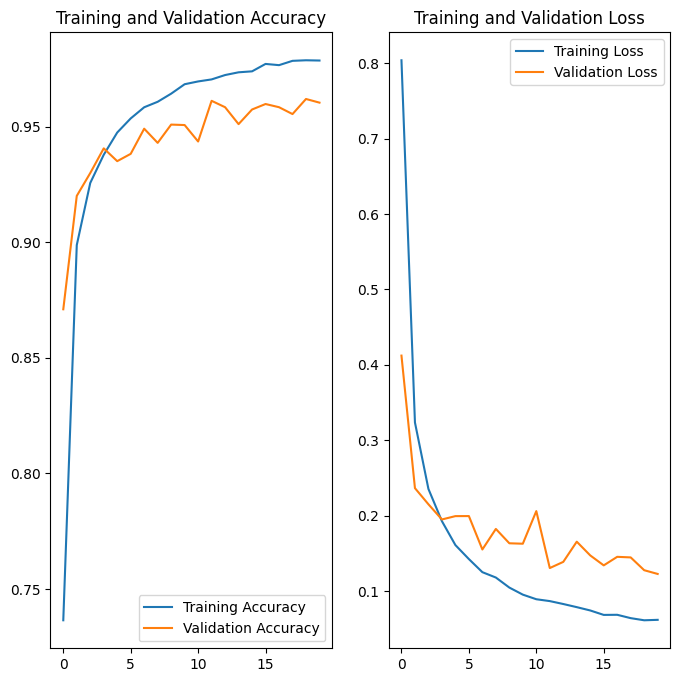

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation
* Test dataset을 이용해서 모델의 성능을 평가합니다.

In [ ]:
model.load_weights(checkpoint_dir)

In [45]:
results = model.evaluate(test_dataset)

317/317 [==============================] - 2s 7ms/step - loss: 0.1228 - accuracy: 0.9605


### 스코어 결과
* 위의 스코어는 분류모델에 적용되는 스코어입니다.
* 모델의 크기 (MB) 와 정확도를 이용해 스코어를 출력합니다.

In [46]:
def final_score():
    print("Model params num : " + str(model.count_params()))
    print("Accuracy : " + str(results[1]))

    s = (model.count_params() * 32) / (1024 ** 2)
    score = 50 * (results[1] + min((1/s), 1))

    print("score : " + str(score))

In [47]:
final_score()

Model params num : 642684
Accuracy : 0.9604899287223816
score : 50.57380527218782
